In [1]:
import numpy as np
import matplotlib.pyplot as plt

Gauss:  [1.0, 1.0, 0.9999999999999999] 28
Jacobi:  [1.0, 1.0, 1.0] 21 1 0.0
Gaus-Seidel:  [1.0, 1.0, 1.0] 21 1 0.0
Cholesky:  [1. 1. 1.] 25
LDL:  [1. 1. 1.] 25


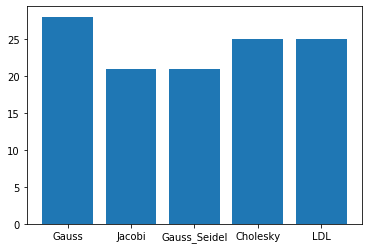

In [10]:
# Numeric methods library
# This is a compilation of the functions that have been used in class

class Numeric:
    def __init__(self):
        self.a = 1
    
    # direct methods
    def gauss(self, A, b):
        """
        A: n by n dimensional numpy array
        b: 1 by n numpy array
        
        return x, flops
        x: solution to Ax = b
        flops: number of flops required for the gaussian
        """   
    
        # check if A and b inputs are correct
        # assert

        flops_count = 0
        m = len(A)
        # Augument matrix A with vector b
        A = np.c_[A, b]

        m = len(A)
        assert all([len(row) == m + 1 for row in A[1:]]), "Matrix rows have non-uniform length"
        n = m + 1

        for k in range(m):
            # get pivots
            pivots = [abs(A[i][k]) for i in range(k, m)]

            # get max of pivots
            i_max = pivots.index(max(pivots)) + k

            # Check for singular matrix
            assert A[i_max][k] != 0, "Matrix is singular!"

            # Swap rows
            A[k], A[i_max] = A[i_max], A[k]

            # check if echelon form is reached as a condition to exit loop
            last_row = A[m-1:][0]
            if all([p == 0 for p in last_row[0:m-1]]):
                break

            for i in range(k + 1, m):
                f = A[i][k] / A[k][k] # one flop
                flops_count += 1
                for j in range(k + 1, n):
                    A[i][j] -= float(A[k][j] * f) # 2 flops
                    flops_count += 2

                # Fill lower triangular matrix with zeros:
                A[i][k] = 0

        # Solve equation Ax=b for an upper triangular matrix A         
        x = []
        for i in range(m - 1, -1, -1):
            x.insert(0, A[i][m] / A[i][i]) # 1 flop
            flops_count += 1
            for k in range(i - 1, -1, -1):
                A[k][m] -= A[k][i] * x[0] # 2 flops
                flops_count += 2
        return x, flops_count
    
    def LLT(self, A, b):
        flops = 0
        # convert A and b to numpy arrays
        A = np.array(A)
        b = np.array(b)
        
        # get size of matrix
        m, n = np.shape(A)
        L = np.zeros((m, n))
        
        for i in range(m):
            for j in range(n):
                if i == j:
                    if j == 0:
                        L[i,i] = np.sqrt(A[i,i]) # 1
                        flops += 1
                    elif j == 1:
                        L[i,i] = np.sqrt(A[i,i] - np.sum([L[j, k]**2 for k in range(0, j)])) #
                        flops += 2
                    else:
                        L[i,i] = np.sqrt(A[i,i] - np.sum([L[j, k]**2 for k in range(0, j)])) #
                        flops += 1 + j
                        
                elif i > j:
                    if j == 0:
                        L[i,j] = A[i,j]/L[j,j]
                        flops += 1   
                    elif j == 1:
                        L[i,j] = (A[i,j] - np.sum([L[i, k]*L[j,k] for k in range(0, j)]))/L[j,j]
                        flops += 2   
                    else:
                        L[i,j] = (A[i,j] - np.sum([L[i, k]*L[j,k] for k in range(0, j)]))/L[j,j]
                        flops += 1 +j   
                    
        y, f = self.forward_substitution(L, b)
        flops += f
        x, f = self.backward_substitution(L.T, y)
        flops += f
        
        return x, L, flops

    
    def LDLT(self, A, b):
        flops = 0
        # convert A and b to numpy arrays
        A = np.array(A)
        b = np.array(b)
        
        # get size of matrix
        m, n = np.shape(A)
        L = np.zeros((m, n))
        d = np.zeros(m)
        
        for i in range(m):
            for j in range(n):
                if j == 0:
                    d[j] = A[j, j]
                elif j == 1:
                    d[j] = A[j, j] - np.sum([L[j, k]**2*d[k] for k in range(j)])
                    flops += 1
                else:
                    d[j] = A[j, j] - np.sum([L[j, k]**2*d[k] for k in range(j)])
                    flops += j
                
                if i > j:
                    if j == 0:
                        L[i, j] = A[i,j]/d[j]
                        flops += 1
                    elif j == 1:
                        L[i, j] = (A[i,j] - np.sum([L[i, k]*L[j,k]*d[k] for k in range(j)]))/d[j]
                        flops += 2
                    else:
                        L[i, j] = (A[i,j] - np.sum([L[i, k]*L[j,k]*d[k] for k in range(j)]))/d[j]
                        flops += j+1
                    
                if i == j:
                    L[i, i] = 1
                                        
        D = np.diag(d, 0)
        
        # forward substitution
        z, f = self.forward_substitution(L, b)
        flops += f
        y, f = self.diagonal_substitution(D, z)
        flops += f
        x, f = self.backward_substitution(L.T, y)
        flops += f
        
        return x, L, D, flops
    
    ########################
    # iterative methods
    
    def jacobi(self, A, b, x0, accuracy):
        
        # coonvert A and b to numpy objects for faster computation
        A = np.array(A)
        b = np.array(b)
        x_k = x0
        
        # get size of A
        m, n = np.shape(A)
        
        flops = 0
        f = []
        
        error = 1
        steps = 0
        while error > accuracy:
            x_k1 = []
            for i in range(m):
                # perform division only once
                if steps == 0:
                    f.append(1/A[i,i]) # i flop
                    flops += 1
                    
                sum = 0
                for j in range(n):
                    if i != j:
                        sum += A[i,j]*x_k[j] # 2 flops
                        flops += 2
                        
                x_k1.append(f[i] * (b[i] - sum)) # 2 flops
                flops += 2
                
            error = self.norm_2(np.array(x_k1)-np.array(x_k))
            x_k = x_k1.copy()
            
            steps += 1
            
        return x_k1, flops, steps, error
    
    def gauss_seidel(self, A, b, x0, accuracy):
    
        # coonvert A and b to numpy objects for faster computation
        A = np.array(A)
        b = np.array(b)
        x_k = x0
        x_k_old = x0.copy()
        
        # get size of A
        m, n = np.shape(A)
        
        flops = 0
        f = []
        
        error = 1
        steps = 0
        while error > accuracy:
            for i in range(m):
                # perform division only once
                if steps == 0:
                    f.append(1/A[i,i]) # i flop
                    flops += 1
                    
                sum = 0
                for j in range(n):
                    if i != j:
                        sum += A[i,j]*x_k[j] # 2 flops
                        flops += 2
                        
                x_k[i] = f[i] * (b[i] - sum) # 2 flops
                flops += 2
                
            error = self.norm_2(np.array(x_k)-np.array(x_k_old))
            x_k_old = x_k.copy()
            steps += 1
            
        return x_k, flops, steps, error
    
    def forward_substitution(self, L, b):
        flops = 0
        m = np.shape(b)[0]
        y = np.zeros(m)
        
        # check if diagonal is unit
        if np.all(L.diagonal() == 1):
            for i in range(m):
                if i == 0:
                    y[i] = b[i] # 0
                elif i == 1:
                    y[i] = (b[i] - np.sum([L[i,k]*y[k] for k in range(i)])) # 1
                    flops += 1
                else:
                    y[i] = (b[i] - np.sum([L[i,k]*y[k] for k in range(i)])) # i
                    flops += i
                    
        else:
            for i in range(m):
                if i == 0:
                    y[i] = 1/L[i,i]*b[i] # 1
                    flops += 1
                elif i == 1:
                    y[i] = 1/L[i,i]*(b[i] - np.sum([L[i,k]*y[k] for k in range(i)])) # 2
                    flops += 2
                else:
                    y[i] = 1/L[i,i]*(b[i] - np.sum([L[i,k]*y[k] for k in range(i)]))
                    flops += i+1
            
        return y, flops
        
    def backward_substitution(self, U, b):
        flops = 0
        m = np.shape(b)[0]
        y = np.zeros(m)
        
        # check if diagonal is unit
        if np.all(U.diagonal() == 1):
            for i in range(1, m+1):
                if i == 0:
                    y[m-i] = b[m-i] # 0
                elif i == 1:
                    y[m-i] = (b[m-i] - np.sum([U[m-i,k]*y[k] for k in range(m-i, m)])) # 1
                    flops += 1
                else:
                    y[m-i] = (b[m-i] - np.sum([U[m-i,k]*y[k] for k in range(m-i, m)]))
                    flops += i
        else:
            for i in range(1, m+1):
                if i == 0:
                    y[m-i] = 1/U[m-i,m-i]*b[m-i] # 1
                    flops += 1
                elif i == 1:
                    y[m-i] = 1/U[m-i,m-i]*(b[m-i] - np.sum([U[m-i,k]*y[k] for k in range(m-i, m)])) # 2
                    flops += 2
                else:
                    y[m-i] = 1/U[m-i,m-i]*(b[m-i] - np.sum([U[m-i,k]*y[k] for k in range(m-i, m)]))
                    flops += i+1
            
        return y, flops
    
    def diagonal_substitution(self, D, b):
        flops = 0
        m = np.shape(b)[0]
        y = np.zeros(m)
        for i in range(m):
            y[i] = b[i]/D[i,i] # 1
            flops += 1
            
        return y, flops
    
    def norm_2(self, v):
        s = 0
        for i in v:
            s += abs(i)**2
        return np.sqrt(s)
            
# A = [[6.0, 5.0, 1], [5, 5, 1], [1, 1, 1]]
A = [[2.0, -1, 0], [-1, 2, -1], [0, -1, 1]]
# b = [6, 9, 8]
b = [1, 0, 0]
x0 = [1, 1, 1]
accuracy = 1e-9

nm = Numeric()
flops_compare = []
# gauss
x, flops_g = nm.gauss(A, b)
print("Gauss: ", x, flops_g)
flops_compare.append(flops_g)

# jacobi
x, flops_j, steps, error = nm.jacobi(A, b, x0, accuracy)
print("Jacobi: ", x, flops_j, steps, error)
flops_compare.append(flops_j)

# gauss_seidel
x, flops_gs, steps, error = nm.gauss_seidel(A, b, x0, accuracy)
print("Gaus-Seidel: ", x, flops_gs, steps, error)
flops_compare.append(flops_gs)

# cholesky
x, L, flops_c = nm.LLT(A, b)
# L@L.T
print("Cholesky: ", x, flops_c)
flops_compare.append(flops_c)

# LDL
x, L, D, flops_ldl = nm.LDLT(A, b)
# L@D@L.T
print("LDL: ", x, flops_ldl)
flops_compare.append(flops_ldl)

# plot flops
fig, ax = plt.subplots()
x = np.arange(5)
ax.bar(x,flops_compare)
plt.xticks(x, ('Gauss', 'Jacobi', 'Gauss_Seidel', 'Cholesky', 'LDL'))

plt.show()